In [5]:
%%capture
!pip install datasets;

In [6]:
from datasets import list_datasets, load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plot

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
all_chars = " !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz`\n"
ctoi = {c:i for i,c in enumerate(all_chars)}
itoc = {i:c for i,c in enumerate(all_chars)}

unknown_i = len(all_chars)
vocab_size = len(all_chars) + 1

In [8]:
# return list of int
def encode(txt):
    return [ctoi.get(c, unknown_i) for c in txt]

def decode(x):
    return "".join([itoc.get(i, "_") for i in x])

## Book Data

In [9]:
dataset = load_dataset("bookcorpus", streaming=True, split="train")

In [10]:
next(iter(dataset))

{'text': 'usually , he would be tearing around the living room , playing with his toys .'}

In [140]:
valid_ds = dataset.take(100000)
train_ds = dataset.skip(100000)

In [141]:
train_itr = iter(train_ds)

In [142]:
txt = [next(train_itr)["text"] for _ in range(10)]
txt

["he honestly cared for mia-anyone could see that-but what would he do if he knew she carried another man 's child ?",
 'he would leave her .',
 'it was that simple .',
 'should she lie to mia ?',
 "pretend it was n't so ?",
 'that would comfort her more than the truth .',
 "but one look at mia 's face told her it was too late for lies .",
 "`` i 'm sorry , '' fila said .",
 "`` it 's hopeless , is n't it ? ''",
 "tears streaked down mia 's cheeks ."]

In [ ]:
x = encode("hello")
decode(x)

'hello'

In [143]:
iter_size = 20
data_itr = {
 "train": iter(train_ds),
 "valid": iter(valid_ds),
}

# return a long string
def step(split):
    global data_itr
    itr = data_itr[split]
    
    try: 
        data = [next(itr)["text"] for _ in range(iter_size)] # list of string
    except StopIteration:
        print("sop")
        data_iter[split] =  iter(train_ds) if split == "train" else iter(valid_ds)
        data = [next(data_iter[split])["text"] for _ in range(iter_size)]
        
    txt = "".join(data)
    return txt
    

# (B, L)
def book_next_batch(split="train", block_size=32, batch_size=32):
    txt = ""
    batch_n = 0
    
    while(batch_n < batch_size): 
        txt += step(split)
        batch_n = (len(txt)-1) // block_size
     
    x = torch.tensor(encode(txt), device=device)
    y = x[1:]
    end_idx = batch_size*block_size
    xb = x[:end_idx].view(-1, block_size)
    yb = y[:end_idx].view(-1, block_size)
            
    return xb, yb


In [82]:
xb, yb = book_next_batch()
xb.shape

torch.Size([32, 32])

In [40]:
xb[1], yb[1]

(tensor([55,  0, 49, 46, 57, 57, 49, 42,  0, 44, 55, 52, 58, 53,  0, 57, 45, 38,
         57,  0, 46,  0, 50, 42, 57,  0, 43, 55, 42, 56, 45, 50]),
 tensor([ 0, 49, 46, 57, 57, 49, 42,  0, 44, 55, 52, 58, 53,  0, 57, 45, 38, 57,
          0, 46,  0, 50, 42, 57,  0, 43, 55, 42, 56, 45, 50, 38]))

In [105]:
xb, yb = book_next_batch()
x = xb[1].tolist()
y = yb[1].tolist()
decode(x), decode(y)

('ensation , lowering herself onto', 'nsation , lowering herself onto ')

In [42]:
ci = [ci for x in xb for ci in x]
unknon_count = [i for i in ci if i == unknown_i]

print(len(ci))
print(len(unknon_count))

1024
0


## Shakespeare Data

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-03-31 08:39:42--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.005s  

2023-03-31 08:39:42 (234 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [21]:
txt = open('input.txt', 'r').read()
txt[0:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [44]:
data = encode(txt)
i = int(0.8 * len(data))

shake_data = {
    "train": data[0:i],
    "valid": data[i:],
}

In [45]:
def shake_next_batch(split="train", block_size=32, batch_size=32):
    data = shake_data[split]
    xi = torch.randint(0, len(data)-block_size, (batch_size,))
    xb = torch.tensor([data[i:i+block_size] for i in xi], device=device)
    yb = torch.tensor([data[i+1:i+block_size+1] for i in xi], device=device)
    
    return xb, yb

In [47]:
x, y = shake_next_batch()
x.shape

torch.Size([32, 32])

## Transfomer Model

In [51]:
#!/usr/bin/env python
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F


@dataclass
class Config:
    vocab_size: int
    block_size: int
    emb_size: int
    head_num: int
    head_size: int
    layer_num: int
    ctoi: dict
    dropout: float


class MultiHeadAttension(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        assert c.emb_size / c.head_size == c.head_num

        self.head_size = c.head_size
        self.head_num = c.head_num
        self.attn = nn.Linear(
            c.emb_size, 3 * c.head_num * c.head_size, bias=False)
        self.ffn = nn.Linear(c.head_num * c.head_size, c.emb_size, bias=False)

        self.attn_dropout = nn.Dropout(c.dropout)
        self.resid_dropout = nn.Dropout(c.dropout)

    # x: (B, L, C)
    # return: (B, L, C)
    def forward(self, x):
        B, L, C = x.shape

        z = self.attn(x)  # (B, L, 3 * hn * hs)
        k, q, v = torch.split(
            z, self.head_num * self.head_size, dim=2)  # (B, L, hn * hs)

        k = k.view(B, L, self.head_num, self.head_size).permute(
            0, 2, 1, 3)  # (B, hn, L, hs)
        q = q.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)
        v = v.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)

        q = q.permute(0, 1, 3, 2)  # (B, hn, hs, L)
        attn = (k @ q) / self.head_size**0.5  # (B, hn, L, L)
        mask = torch.tril(torch.ones(L, L)) == 0
        mask = mask.to(x.device)
        attn = attn.masked_fill(mask, -float('inf'))  # (B, hn, L, L)
        attn = F.softmax(attn, dim=3)
        attn = self.attn_dropout(attn)

        y = attn @ v  # (B, hn, L, hs)
        y = y.permute(0, 2, 1, 3)  # (B, L, hn, hs)
        y = y.contiguous().view(B, L, -1)  # (B, L, hn * hs)
        y = self.ffn(y)  # (B, L, C)
        y = self.resid_dropout(y)

        return y


class FeedForward(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.linear1 = nn.Linear(c.emb_size, 2 * c.emb_size)
        self.linear2 = nn.Linear(2 * c.emb_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)

    # (B, L, C)
    def forward(self, x):
        y = self.linear1(x)
        y = torch.relu(y)
        y = self.linear2(y)
        y = self.dropout(y)

        return y


class Block(nn.Module):

    def __init__(self, c: Config):
        super().__init__()

        assert c.emb_size % c.head_size == 0
        assert c.emb_size / c.head_size == c.head_num

        self.mha = MultiHeadAttension(c)
        self.lnorm1 = nn.LayerNorm(c.emb_size)
        self.lnorm2 = nn.LayerNorm(c.emb_size)
        self.ffn = FeedForward(c)

    # x: (B, L, emb)
    def forward(self, x):
        y = self.mha(x) + x
        y = self.lnorm1(y)
        y = self.ffn(y) + y
        y = self.lnorm2(y)
        return y


class Transformer(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.config = c
        self.embed = nn.Embedding(c.vocab_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)
        self.blocks = nn.Sequential(
            *[Block(c) for _ in range(c.layer_num)]
        )
        self.proj = nn.Linear(c.emb_size, c.vocab_size)

    # return (L, C)
    def pos_encoding(self, x):
        B, L, C = x.shape
        pos = torch.arange(0, L).view(-1, 1)  # (L, 1)
        div = 2 * torch.arange(0, C) / C  # (C)
        div = torch.pow(10000, div)  # (C)
        e = pos / div
        pe = torch.zeros(L, C)
        pe[:, 0::2] = torch.sin(e[:, 0::2])
        pe[:, 1::2] = torch.cos(e[:, 1::2])

        pe = pe.to(x.device)
        return pe

    # (B, L) -> (B, L, C)
    def forward(self, x):        
        y = self.embed(x)  # (B, L, emb)
        y = y + self.pos_encoding(y)  # (B, L, emb)
        y = self.dropout(y)
        y = self.blocks(y)  # (B, L, emb)
        y = self.proj(y)  # (B, L, vocab)

        return y

    @torch.no_grad()
    def sample(self, max_len):
        device = next(self.parameters()).device
    
        self.eval()
        itoc = {i: c for c, i in self.config.ctoi.items()}
        tks = [0] * self.config.block_size

        for i in range(max_len):
            ctx = torch.tensor(tks[i:i+self.config.block_size], device=device)  # (L)
            ctx = ctx.view(1, -1)  # (B, L)

            logits = self.forward(ctx)  # (B, L, C)
            probs = F.softmax(logits, dim=2)  # (B, L, C)
            # (C), # the last in the sequence is the newly generated
            probs = probs[0, -1, :]
            yi = torch.multinomial(probs, 1)
            tks.append(yi.item())

        tks = tks[self.config.block_size:]
        chars = [itoc.get(t, "_") for t in tks]
        self.train()
        return "".join(chars)

In [120]:
def fit(next_batch_fn, batch_size, epoch, eval_n, optim):
    lossi = []
    model.train()
    eval_iterval = epoch // eval_n
    
    for i in range(epoch):
        optim.zero_grad()
        xb, yb = next_batch_fn("train", cfg.block_size, batch_size) # (B, L) 
        logits = model(xb)
        B, L, C = logits.shape

        logits = logits.view(B*L, C)
        yb = yb.view(-1)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optim.step()

        if i % eval_iterval == 0:
            tr_loss = eval_split(model, next_batch_fn, "train", cfg.block_size, batch_size, eval_size=256)
            va_loss = eval_split(model, next_batch_fn, "valid", cfg.block_size, batch_size, eval_size=256)
            lossi.append((tr_loss, va_loss))
            print(f"{tr_loss:.4f} {va_loss:.4f}")
            
    return lossi

In [132]:
@torch.no_grad()
def eval_split(model, next_batch_fn, split, block_size, batch_size, eval_size):
    model.eval()
    n = eval_size // batch_size
    lossi = []

    for _ in range(n):
        xb, yb = next_batch_fn(split, block_size, batch_size)
        logits = model(xb)
        B, L, C = logits.shape
        logits = logits.view(B*L, C)
        yb = yb.view(-1)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

    model.train()
    return sum(lossi) / n

In [133]:
cfg = Config(
    vocab_size=vocab_size,
    block_size=64,
    emb_size=64,
    head_size=32,
    head_num=64//32,
    layer_num=2,
    ctoi=ctoi,
    dropout=0
)

model = Transformer(cfg)
model = model.to(device)
param_n = sum([_.numel() for _ in model.parameters()])

f"{param_n:,}", device

('75,075', device(type='cpu'))

# Training with only Shakespeare

In [135]:
optim = torch.optim.Adam(model.parameters())
lossi = fit(book_next_batch, batch_size=32, epoch=3000, eval_n=10, optim=optim)

1.6804 1.7390
1.5239 1.6476
1.5756 1.6562
1.5685 1.6044
1.5540 1.6437
1.5813 1.6134
1.5754 1.6408
1.5585 1.6352
1.5881 1.6609
1.5233 1.6041


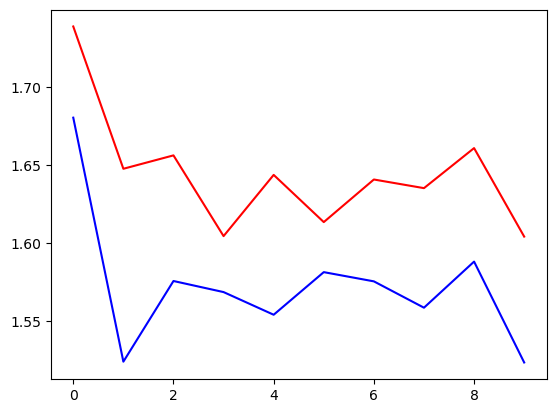

In [136]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [138]:
tr_loss = eval_split(model, book_next_batch, "train", cfg.block_size, batch_size, 2056)
va_loss = eval_split(model, book_next_batch, "valid", cfg.block_size, batch_size, 2056)

f"{tr_loss:.4f}", f"{va_loss:.4f}"

sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop
sop


KeyboardInterrupt: 

In [91]:
print(model.sample(300))

bout he had he worra no i 'dell , '' turnished wint the alw his have knew to gan me , regled with he kirness on .he hels sping next unnheving a she 'd one , even not . ''he spocepted to date , the proobcing his , still he girms was steep its not the pleasing up conty his gain .every new way uperatio
